In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling2D, LSTM
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, RepeatVector, Reshape
from keras.optimizers import rmsprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from datetime import datetime

Using TensorFlow backend.


# Building the dataset

In [2]:
labelled_data_path = '/Users/rym.laabiyad/RogerVoice/data_1s/labelled/'

data_path_actors = 'Audio_Speech_Actors_01-24/'
data_path_4men = '4men/'
data_path_toronto = 'UniversityOfToronto/'
data_path_youtube = 'youtube/'
data_path_RVmeeting = 'RVmeeting/'
data_path_UrbanSounds = 'UrbanSounds/'
data_paths = [data_path_4men,
              data_path_youtube, 
              data_path_toronto, 
              data_path_actors,
              data_path_RVmeeting]

feature_engineering_path = '/Users/rym.laabiyad/RogerVoice/data_1s/feature_engineering/'
models_path = '/Users/rym.laabiyad/RogerVoice/models/'

n_labels = 5

n_mfcc = 12

compute_librosa_features = False
librosa_features_filename = str(n_labels) + 'labels_librosa_features_' + str(n_mfcc) + '_mfcc.pkl'
librosa_avg_and_std_filename = str(n_labels) + 'labels_librosa_features_' + str(n_mfcc) + '_mfcc_avg_and_std.pkl'

compute_amplitude_features = False
amplitude_features_filename = str(n_labels) + 'labels_amplitude.pkl'

compute_2d_mfcc = True
compute_2d_mfcc_chroma = False
compute_2d_vgg = False

scale = False
scaler_filename = 'scaler.pkl'

train_models = False
# For deep learning models
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
TRAIN_TEST_RATIO = 0.2

proba = False

plt.style.use(['dark_background'])

In [3]:
def get_labels_dict(n_labels):
    if n_labels == 3:
        labels_dict = {'neutral': 1, 'happy': 1, 
                       'inaudible': 2,
                       'sad': 3, 'angry': 3, 
                       'disgusted': -1, 'scared': -1, 'surprised': -1}
    if n_labels == 4:
        labels_dict = {'neutral': 1, 'happy': 1, 
                       'inaudible': 2,
                       'sad': 3, 'angry': 4,         
                      'disgusted': -1, 'scared': -1, 'surprised': -1}
    elif n_labels == 5:
        labels_dict = {'neutral': 0, 'happy': 1, 
                       'inaudible': 2,
                       'sad': 3, 
                       'angry': 4,               
                       'disgusted': -1, 'scared': -1, 'surprised': -1}
    elif n_labels == 7:
        labels_dict = {'neutral': 0, 'happy': 1, 
                       'inaudible': 2,
                       'sad': 3, 
                       'angry': 4,               
                       'disgusted': 5, 
                       'scared': 6, 
                       'surprised': 7}
        
    return labels_dict


def get_reverse_labels_dict(n_labels):
    if n_labels == 3:
        reverse_labels_dict = {1: 'neutral/positive',                         
                               2: 'inaudible',
                               3: 'negative'}
    if n_labels == 4:
        reverse_labels_dict = {1: 'neutral/positive', 
                               2: 'inaudible',
                               3: 'sad',
                               4: 'angry'}
    elif n_labels == 5:
        reverse_labels_dict = {0: 'neutral', 
                               1: 'happy', 
                               2: 'inaudible',
                               3: 'sad', 
                               4: 'angry'}
        
    return reverse_labels_dict

In [4]:
labels_dict = get_labels_dict(n_labels)
print(labels_dict)

if n_labels <= 5:
    reverse_labels_dict = get_reverse_labels_dict(n_labels)
    print(reverse_labels_dict)

{'neutral': 0, 'happy': 1, 'inaudible': 2, 'sad': 3, 'angry': 4, 'disgusted': -1, 'scared': -1, 'surprised': -1}
{0: 'neutral', 1: 'happy', 2: 'inaudible', 3: 'sad', 4: 'angry'}


In [5]:
def get_label_from_foldername(foldername, labels_dict):
    return labels_dict[foldername]
    
def create_dataset(root_data_path, data_path, labels_dict):
    paths = []
    labels = []
    
    for folder in os.listdir(os.path.join(root_data_path, data_path)):     
        if not folder.startswith('.') and not folder.endswith('.wav'):
            path = os.path.join(data_path, folder)
            label = get_label_from_foldername(folder, labels_dict)

            for file in os.listdir(os.path.join(root_data_path, path)):
                if file.endswith('.wav'):
                    paths.append(os.path.join(path, file))
                    labels.append(label)
                    
    recordings = pd.DataFrame({'paths': paths, 'labels': labels})
    recordings.drop(recordings[recordings['labels'] < 0].index,
                                          inplace=True)
                    
    return recordings


def get_labelled_data(root_data_path, data_paths, labels_dict):
    recordings = pd.DataFrame({'paths': [], 'labels': []})
    for data_path in data_paths:
        recordings = pd.concat([recordings, 
                                create_dataset(root_data_path, data_path, labels_dict)],
                              ignore_index=True)
    return recordings

# Feature Engineering

### Source : Wikipedia
    
In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum").

MFCCs are commonly derived as follows:

- Take the Fourier transform of (a windowed excerpt of) a signal.
- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
- Take the logs of the powers at each of the mel frequencies.
- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
- The MFCCs are the amplitudes of the resulting spectrum.

N.B : cepstrum is the information of rate of change in spectral bands

In [6]:
def extract_amplitude_features(path, root_data_path, filter_amplitude=0.003):
    audio_data, sample_rate = librosa.load(os.path.join(root_data_path, path))
    
    filtered_audio = audio_data[(audio_data >= filter_amplitude) | (audio_data <= -filter_amplitude)]
    signal2noise_ratio = len(filtered_audio)/len(audio_data)
     
    return np.mean(audio_data), min(audio_data), max(audio_data), signal2noise_ratio


def extract_librosa_features(path, root_data_path, n_mfcc=12):
    audio_data, sample_rate = librosa.load(os.path.join(root_data_path, path))
    
    mfcc_features = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc), axis=1)

    stft = np.abs(librosa.stft(audio_data))
    chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
    contrast_features = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)

    tonnetz_features = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_data), sr=sample_rate), axis=1)
    
    return mfcc_features, chroma_features, contrast_features, tonnetz_features


def get_average_and_std(features):
    return np.concatenate([np.mean(features, axis=1), np.std(features, axis=1)])


def extract_librosa_avg_and_std(path, root_data_path, n_mfcc=12):
    audio_data, sample_rate = librosa.load(os.path.join(root_data_path, path))
    
    mfcc_features = get_average_and_std(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc))

    stft = np.abs(librosa.stft(audio_data))
    chroma_features = get_average_and_std(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
    contrast_features = get_average_and_std(librosa.feature.spectral_contrast(S=stft, sr=sample_rate))

    tonnetz_features = get_average_and_std(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_data), sr=sample_rate))
    
    return mfcc_features, chroma_features, contrast_features, tonnetz_features


def extract_features(func, recordings, root_data_path, n_mfcc=None, multiple_features=False):  
    start = datetime.now()

    if n_mfcc == None:
        features = recordings.paths.apply(func, args=(root_data_path,)) 
    else:
        features = recordings.paths.apply(func, args=(root_data_path, n_mfcc)) 
    print('Extracting features took {}'.format(datetime.now()-start))
    
    if multiple_features:
        features_df = pd.DataFrame()
        for f in map(list, zip(*features)):
            f_df = pd.DataFrame(f)
            features_df = pd.concat([features_df, f_df], axis=1)
        
    else:
        features_df = pd.DataFrame(features.values.tolist())

    recordings_with_features = pd.concat([recordings, features_df], axis=1)
    recordings_with_features.fillna(0, inplace=True)
    
    return recordings_with_features


def extract_2d_features(path, root_data_path, n_mfcc=12, chroma=False):
    audio_data, sample_rate = librosa.load(os.path.join(root_data_path, path))
    
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    
    if chroma:
        stft = np.abs(librosa.stft(audio_data))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    
        return np.concatenate([mfcc, chroma])
    else:
        return mfcc

In [7]:
if compute_librosa_features:
    recordings = get_labelled_data(labelled_data_path, data_paths, labels_dict)    
    recordings_librosa_features = extract_features(extract_librosa_features, 
                                                   recordings,
                                                   labelled_data_path,
                                                   n_mfcc=12,
                                                   multiple_features=True) 
    recordings_librosa_features.columns = np.concatenate([['paths', 'labels'],
                                                          ['avg_mfcc'+str(i+1) for i in range(n_mfcc)], 
                                                          ['avg_chroma'+str(i) for i in range(1,13)],
                                                          ['avg_contrast'+str(i) for i in range(1,8)], 
                                                          ['avg_tonnetz'+str(i) for i in range(1,7)]
                                                         ])
    recordings_librosa_features.to_pickle(os.path.join(feature_engineering_path, librosa_features_filename))
    
    recordings_librosa_avg_and_std.columns = np.concatenate([['paths', 'labels'],
                                                             ['avg_mfcc'+str(i+1) for i in range(n_mfcc)], 
                                                             ['std_mfcc'+str(i+1) for i in range(n_mfcc)],
                                                             ['avg_chroma'+str(i) for i in range(1,13)],
                                                             ['std_chroma'+str(i) for i in range(1,13)],
                                                             ['avg_contrast'+str(i) for i in range(1,8)], 
                                                             ['std_contrast'+str(i) for i in range(1,8)],
                                                             ['avg_tonnetz'+str(i) for i in range(1,7)],
                                                             ['std_tonnetz'+str(i) for i in range(1,7)]
                                                            ])
    recordings_librosa_avg_and_std.to_pickle(os.path.join(feature_engineering_path, librosa_avg_and_std_filename))
    
else:
    recordings_librosa_features = pd.read_pickle(os.path.join(feature_engineering_path, librosa_features_filename))
    recordings_librosa_avg_and_std = pd.read_pickle(os.path.join(feature_engineering_path, librosa_avg_and_std_filename))
    recordings = recordings_librosa_features.iloc[:,:2]
    
print(recordings_librosa_features.shape)

unique, counts = np.unique(recordings_librosa_features.labels, return_counts=True)
print('Labels distribution:', dict(zip(unique, counts)))

(7558, 39)
Labels distribution: {0.0: 2989, 1.0: 1264, 2.0: 579, 3.0: 1313, 4.0: 1413}


In [8]:
if compute_amplitude_features:
    recordings_amplitude_features = extract_features(extract_amplitude_features, 
                                                     recordings,
                                                     labelled_data_path,
                                                     multiple_features=True) 
    recordings_amplitude_features.columns = ['paths', 'labels', 'amplitude_average', 'amplitude_min', 'amplitude_max', 's2n_ratio']
    recordings_amplitude_features.to_pickle(os.path.join(feature_engineering_path, amplitude_features_filename))

else:
    recordings_amplitude_features = pd.read_pickle(os.path.join(feature_engineering_path, 
                                                                amplitude_features_filename))
    
print(recordings_amplitude_features.shape)

unique, counts = np.unique(recordings_amplitude_features.labels, return_counts=True)
print('Labels distribution:', dict(zip(unique, counts)))

(7558, 6)
Labels distribution: {0.0: 2989, 1.0: 1264, 2.0: 579, 3.0: 1313, 4.0: 1413}


In [9]:
def reduce_class(recordings, biggest_class, ideal_class, seed=42):
    np.random.seed(seed)
    
    recordings_biggest_class = recordings[recordings.labels == biggest_class].index.tolist()
    recordings_ideal_class = recordings[recordings.labels == ideal_class].index.tolist()
    
    to_drop = np.random.choice(recordings_biggest_class, 
                               len(recordings_biggest_class)-len(recordings_ideal_class),
                               False)
    recordings.drop(index=to_drop, inplace=True)
        
    return recordings


def augment_class(recordings, label):
    inaudible = recordings[recordings.labels == label]
    recordings = pd.concat([recordings, inaudible], axis=0, ignore_index=True)
    
    return recordings


def balance_classes(recordings, n_labels, seed=42):
    if n_labels == 3:
        recordings = reduce_class(recordings, 1, 3, seed)       
    elif n_labels == 4:
        recordings = reduce_class(recordings, 1, 4, seed)
    elif n_labels == 5:
        recordings = reduce_class(recordings, 0, 4, seed)
    
    return recordings

In [10]:
# Balance the classes
recordings = balance_classes(recordings, n_labels)
recordings_librosa_features = balance_classes(recordings_librosa_features, n_labels)
recordings_librosa_avg_and_std = balance_classes(recordings_librosa_avg_and_std, n_labels)
recordings_amplitude_features = balance_classes(recordings_amplitude_features, n_labels)

balanced_recordings = augment_class(recordings, 2)
unique, counts = np.unique(balanced_recordings.labels, return_counts=True)
print('Labels distribution:', dict(zip(unique, counts)))

Labels distribution: {0.0: 1413, 1.0: 1264, 2.0: 1158, 3.0: 1313, 4.0: 1413}


In [11]:
if compute_2d_mfcc:
    start = datetime.now()
    features_mfcc = balanced_recordings.paths.apply(extract_2d_features, 
                                                    args=(labelled_data_path, n_mfcc, False)).values
    print('Extracting MFCC 2D features took {}'.format(datetime.now()-start))

    features_2d_mfcc = np.zeros((features_mfcc.shape[0], 
                                 features_mfcc[0].shape[0], 
                                 features_mfcc[0].shape[1]))
    for i in range(features_mfcc.shape[0]):
        features_2d_mfcc[i] = features_mfcc[i]

    print(features_2d_mfcc.shape)

Extracting MFCC 2D features took 0:11:00.608788
(6561, 12, 44)


In [14]:
if compute_2d_mfcc_chroma:
    start = datetime.now()
    features_mfcc_chroma = balanced_recordings.paths.apply(extract_2d_features, 
                                                           args=(labelled_data_path, n_mfcc, True)).values
    print('Extracting MFCC and chroma 2D features took {}'.format(datetime.now()-start))

    features_2d_mfcc_chroma = np.zeros((features_mfcc_chroma.shape[0], 
                                        features_mfcc_chroma[0].shape[0], 
                                        features_mfcc_chroma[0].shape[1]))
    for i in range(features_mfcc_chroma.shape[0]):
        features_2d_mfcc_chroma[i] = features_mfcc_chroma[i]

    print(features_2d_mfcc_chroma.shape)

In [15]:
if compute_2d_vgg:
    start = datetime.now()
    balanced_recordings = augment_class(recordings, 2)
    features_vgg = balanced_recordings.paths.apply(extract_2d_features, 
                                      args=(labelled_data_path, 20, True)).values
    print('Extracting 2D features for VGG took {}'.format(datetime.now()-start))

    features_2d_vgg = np.zeros((features_vgg.shape[0], features_vgg[0].shape[0], features_vgg[0].shape[1]))
    for i in range(features_vgg.shape[0]):
        features_2d_vgg[i] = features_vgg[i]

    print(features_2d_vgg.shape)

## Feature distribution depending on class

In [49]:
def plot_features_distribution(recordings, reverse_labels_dict):
    if len(recordings.columns) > 6:
        plt.figure(figsize=(15, 20))
    else:
        plt.figure(figsize=(15,10))
    labels = np.unique(recordings.labels)
    i = 1
    for feature in recordings.columns[1:]:
        for label in labels:
            plt.subplot(len(recordings.columns)-1, len(labels), i)
            sample = recordings[recordings.labels == label]
            plt.hist(sample[feature])

            if feature == recordings.columns[1]:
                plt.title(reverse_labels_dict[int(label)])

            if label == min(labels):
                plt.ylabel(feature)

            i += 1
    plt.show()

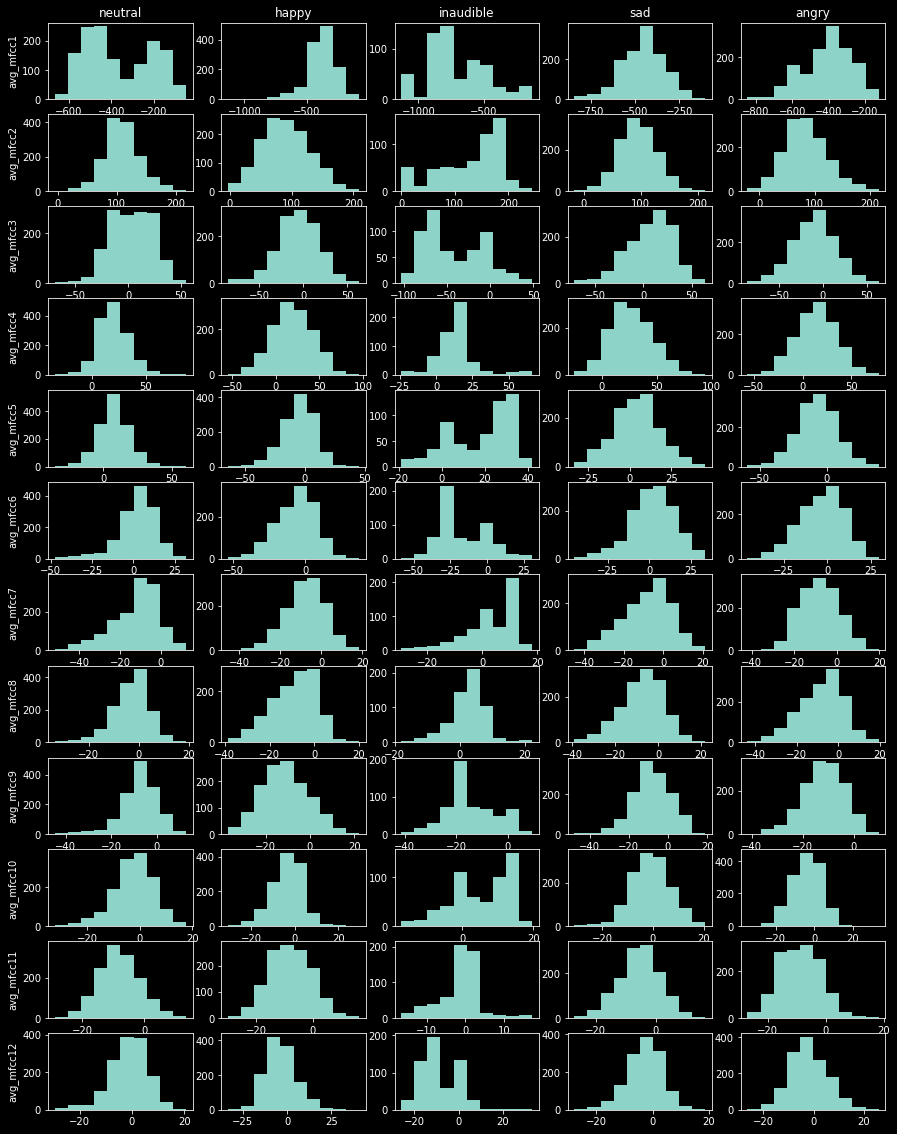

In [36]:
plot_features_distribution(recordings_librosa_features.iloc[:,1:n_mfcc+2], reverse_labels_dict)

Index(['labels', 'avg_chroma1', 'avg_chroma2', 'avg_chroma3', 'avg_chroma4',
       'avg_chroma5', 'avg_chroma6', 'avg_chroma7', 'avg_chroma8',
       'avg_chroma9', 'avg_chroma10', 'avg_chroma11', 'avg_chroma12'],
      dtype='object')


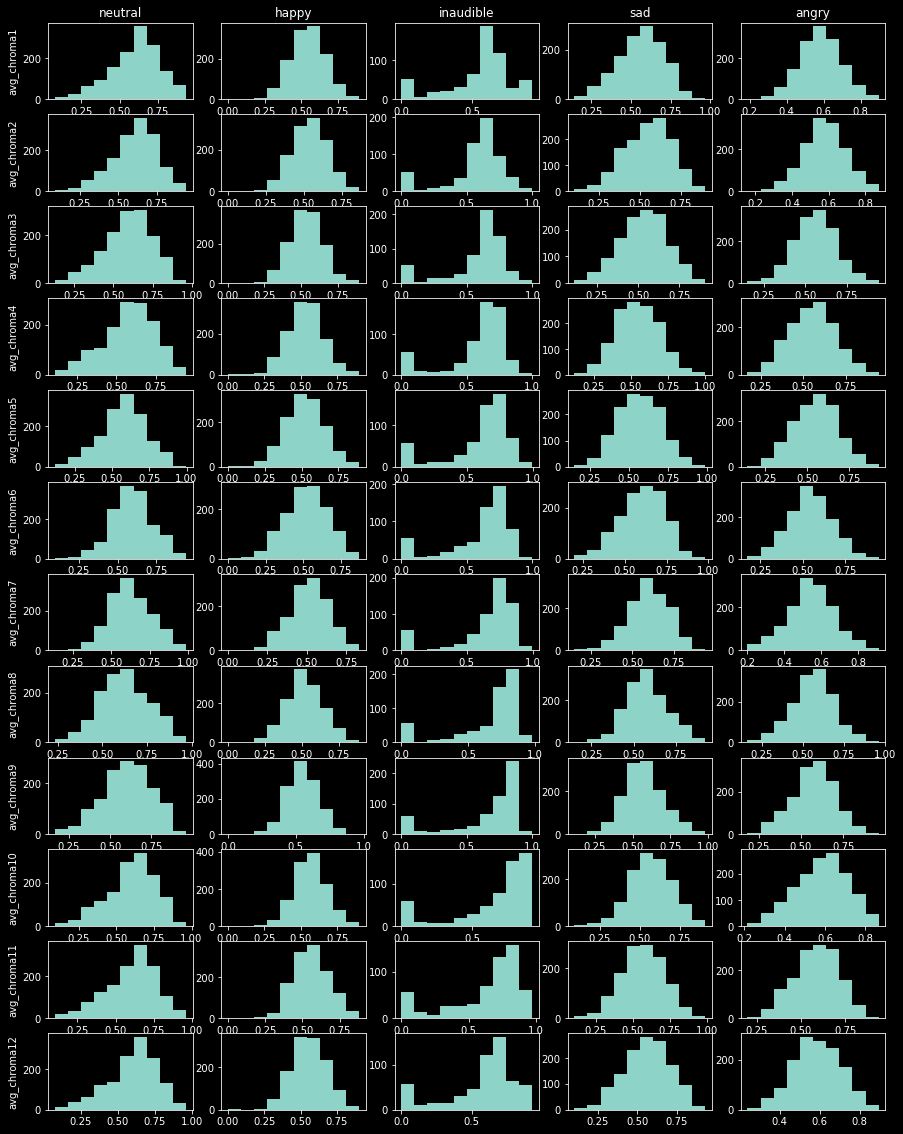

In [44]:
plot_features_distribution(recordings_librosa_features.iloc[:, np.concatenate([[1], range(n_mfcc+2, n_mfcc+14)])], 
                           reverse_labels_dict)

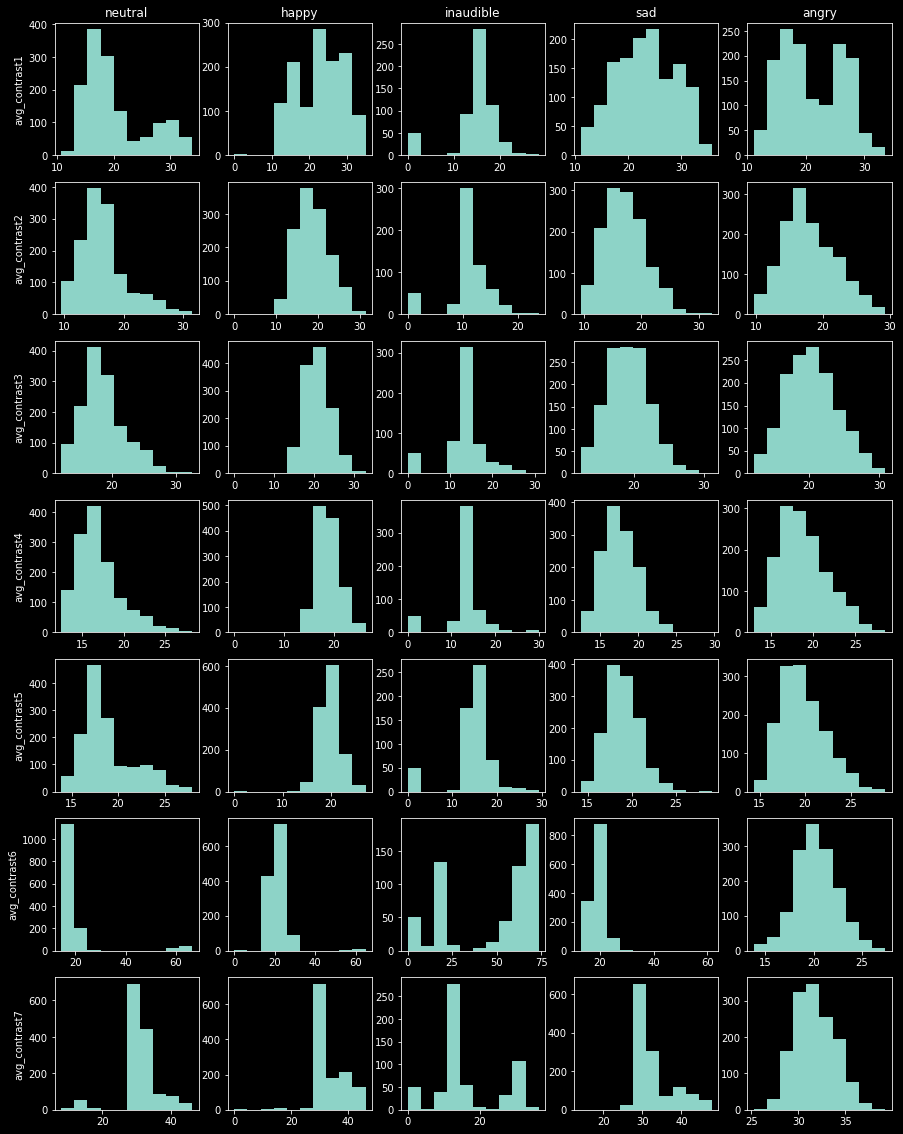

In [50]:
plot_features_distribution(recordings_librosa_features.iloc[:, np.concatenate([[1], range(n_mfcc+14, n_mfcc+14+7)])], 
                           reverse_labels_dict)

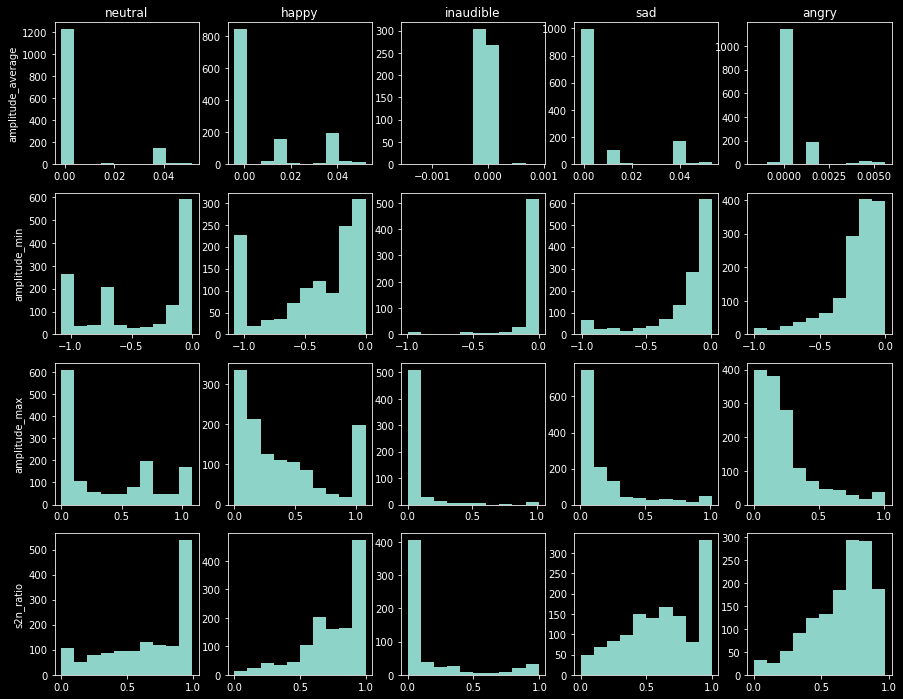

In [51]:
plot_features_distribution(recordings_amplitude_features.iloc[:,1:], reverse_labels_dict)

## Building and evaluating models

In [12]:
def prepare_data(X, y, test_size=0.2, random_state=42, cnn=False, input_dimension=1, scale=False):
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        pickle.dump(scaler, open(os.path.join(feature_engineering_path, scaler_filename), 'wb')) 
        X = scaler.transform(X)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)    
    if cnn:
        X_train_cnn = np.expand_dims(X_train, axis=input_dimension+1)
        X_test_cnn = np.expand_dims(X_test, axis=input_dimension+1)
        y_train_cnn = pd.get_dummies(y_train).to_numpy()
        y_test_cnn = pd.get_dummies(y_test).to_numpy()
    
        return X_train, X_test, y_train, y_test, X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn
    else:
        return X_train, X_test, y_train, y_test
    

def pad_2d_features(X_2d, ideal_size=32):
    padded_X_2d = np.concatenate([X_2d, np.zeros((X_2d.shape[0], 
                                                  ideal_size-X_2d.shape[1],
                                                  X_2d.shape[2],
                                                  1))], 
                                 axis=1)
    return padded_X_2d

In [13]:
recordings_librosa_avg_and_amplitude = recordings_librosa_features.\
                                        merge(recordings_amplitude_features.drop('labels', axis=1), on='paths')
recordings_librosa_avg_and_amplitude = augment_class(recordings_librosa_avg_and_amplitude, 2)
print(recordings_librosa_avg_and_amplitude.shape)
unique, counts = np.unique(recordings_librosa_avg_and_amplitude.labels, return_counts=True)
print('Labels distribution:', dict(zip(unique, counts)))

(6561, 43)
Labels distribution: {0.0: 1413, 1.0: 1264, 2.0: 1158, 3.0: 1313, 4.0: 1413}


In [14]:
recordings_librosa_avg_std_and_amplitude = recordings_librosa_avg_and_std.\
                                            merge(recordings_amplitude_features.drop('labels', axis=1), on='paths')
recordings_librosa_avg_std_and_amplitude = augment_class(recordings_librosa_avg_std_and_amplitude, 2)
print(recordings_librosa_avg_std_and_amplitude.shape)
unique, counts = np.unique(recordings_librosa_avg_std_and_amplitude.labels, return_counts=True)
print('Labels distribution:', dict(zip(unique, counts)))

(6561, 80)
Labels distribution: {0.0: 1413, 1.0: 1264, 2.0: 1158, 3.0: 1313, 4.0: 1413}


In [32]:
X_avg = np.array(recordings_librosa_avg_and_amplitude.iloc[:,2:])
X_avg_std = np.array(recordings_librosa_avg_std_and_amplitude.iloc[:,2:])
y = np.array(recordings_librosa_avg_and_amplitude.iloc[:,1])

X_avg_train, X_avg_test, y_train, y_test, \
    X_avg_train_cnn, X_avg_test_cnn, y_train_cnn, y_test_cnn \
    = prepare_data(X_avg, y, TRAIN_TEST_RATIO, cnn=True, scale=scale)
print(X_avg_train.shape, X_avg_test.shape)

X_avg_std_train, X_avg_std_test, _, _, \
    X_avg_std_train_cnn, X_avg_std_test_cnn, _, _ \
    = prepare_data(X_avg_std, y, TRAIN_TEST_RATIO, cnn=True, scale=scale)
print(X_avg_std_train.shape, X_avg_std_test.shape)

(5248, 41) (1313, 41)
(5248, 78) (1313, 78)


In [52]:
if compute_2d_mfcc:
    _, _, _, _, X_2d_train_mfcc, X_2d_test_mfcc, y_2d_train_mfcc, y_2d_test_mfcc = prepare_data(features_2d_mfcc, 
                                                                                                balanced_recordings.labels, 
                                                                                                TRAIN_TEST_RATIO,
                                                                                                cnn=True, 
                                                                                                input_dimension=2, scale=scale)

    print(X_2d_train_mfcc.shape, X_2d_test_mfcc.shape)

(5248, 12, 44, 1) (1313, 12, 44, 1)


In [56]:
if compute_2d_mfcc_chroma:
    _, _, _, _, X_2d_train_mfcc_chroma, X_2d_test_mfcc_chroma, y_2d_train_mfcc_chroma, y_2d_test_mfcc_chroma \
        = prepare_data(features_2d_mfcc_chroma, balanced_recordings.labels, 
                       TRAIN_TEST_RATIO, cnn=True, input_dimension=2, scale=scale)

    print(X_2d_train_mfcc_chroma.shape, X_2d_test_mfcc_chroma.shape)

In [57]:
if compute_2d_vgg:
    _, _, _, _, X_2d_train_vgg, X_2d_test_vgg, \
                y_2d_train_vgg, y_2d_test_vgg \
        = prepare_data(features_2d_vgg, balanced_recordings.labels, TRAIN_TEST_RATIO, cnn=True, input_dimension=2, scale=scale)

    print(X_2d_train_vgg.shape, X_2d_test_vgg.shape)

In [33]:
def get_predictions_from_probas(probas):
    if n_labels < 5:
        predictions = [p+1 for p in probas.argmax(axis=1)]
    else:
        predictions = probas.argmax(axis=1)
        
    return predictions


def train_model(model, X_train, y_train, models_path, model_filename, params_or_opt, cnn=False):
    if cnn:
        model.compile(loss='categorical_crossentropy', optimizer=params_or_opt, metrics=['accuracy'])

        callbacks = [early_stop, ModelCheckpoint(os.path.join(models_path, model_filename),
                                                 monitor='val_loss', 
                                                 save_best_only=True, 
                                                 mode='min',
                                                 verbose=0)]
        history = model.fit(X_train, y_train, 
                            batch_size=32, epochs=40, validation_split=0.2,
                            callbacks=callbacks)
        return model, history
        
    else:
        model = GridSearchCV(model, params_or_opt, cv=5, n_jobs=-1)
        start = datetime.now()
        model.fit(X_train, y_train)
        print('Training took', datetime.now() - start)

        # save the model to disk
        pickle.dump(model, open(os.path.join(models_path, model_filename), 'wb'))
        
        return model


def evaluate_model(model, X_test, y_test, proba):
    print('Accuracy of the model: {}'.format(model.score(X_test, y_test)))
    
    if proba:
        probas = model.predict_proba(X_test)
        preds = get_predictions_from_probas(probas)

        print(confusion_matrix(y_test, preds))
        res = pd.DataFrame({'real':y_test, 'predicted': preds})
        res = pd.concat([res, pd.DataFrame(100*probas)], axis=1, ignore_index=True)
        res.columns = np.concatenate([['real', 'predicted'], 
                                         [reverse_labels_dict[int(label)] for label in np.unique(y_train)]])
    else:
        preds = model.predict(X_test)
        print(confusion_matrix(y_test, preds))
        res = pd.DataFrame({'real':y_test, 'predicted':preds})
    # TODO : What should be done with the results (dataframe res)? Return it?
    
def top_cv_results(model, n=5):
    cv_results = pd.DataFrame(model.cv_results_)
    cv_results.sort_values(by='rank_test_score', axis=0, inplace=True)
    return cv_results.head(n=n)
        

def plot_cv_results(model, params, plot_title=''):
    plt.figure(figsize=(10, 8))
    cv_results = pd.DataFrame(model.cv_results_)
    
    if len(params) == 1:
        scores = np.array(cv_results['mean_test_score']).reshape(len(param_values))

        plt.plot(param_values, scores)
        plt.xlabel(param_name)
        
    elif len(params) == 2:
        param1, param2 = params.keys()
        scores = np.array(cv_results['mean_test_score']).reshape(len(params[param1]), len(params[param2]))
        for i, value in enumerate(params[param1]):
            plt.plot(params[param2], scores[i], label=param1 + str(value))
        plt.legend()
        plt.xlabel(param2)

    elif len(params) == 3: 
        for i, (param_name, param_values) in enumerate(params.items()):
            param1 = params.keys()[(i+1)%3]
            param2 = params.keys()[(i+2)%3]
            for j, fixed_value in enumerate(param_values):
                plt.subplot(3, 6, j+1)
                tmp_cv_results = cv_results[cv_results['params'][param_name] == fixed_value]
                scores = np.array(tmp_cv_results['mean_test_score']).reshape(len(param1), len(param2))
                for k, value in enumerate(params[param1]):
                    plt.plot(params[param2], scores[k], label=param1 + str(value))
                plt.legend()
                plt.xlabel(param2)
            
    plt.ylabel('Average accuracy')
    plt.title(plot_title + ' for ' + str(n_labels)+ ' labels')
    plt.show()

In [35]:
model_filename = str(n_labels) + 'labels_model_xgb_1s_mfcc_' + str(n_mfcc) + '_librosa_avg_and_amplitude.sav'
if scale:
    name, extension = model_filename.split('.')
    model_filename = name + '_scaled.' + extension

params = {'max_depth': [6, 7, 8, 9, 10],
          'n_estimators': [15, 16, 17, 18, 19, 20]}

if train_models:
    model_xgb = XGBClassifier(objective='multi:softmax', class_weight='balanced', learning_rate=0.5)      
    model_xgb = train_model(model_xgb, X_train, y_train, models_path, model_filename, params)

else:
    model_xgb = pickle.load(open(os.path.join(models_path, model_filename), 'rb'))
    
evaluate_model(model_xgb, X_avg_test, y_test, proba)
print('Model saved at {}'.format(model_filename))

Accuracy of the model: 0.8758568164508759
[[236   1   7  16   2]
 [  3 231   2  24  21]
 [  0   0 216   0   0]
 [  3  23   4 222  19]
 [  4  18   3  13 245]]
Model saved at 5labels_model_xgb_1s_mfcc_12_librosa_avg_and_amplitude.sav


In [36]:
plot_cv_results(model_xgb, params, 'XGBoost gridsearch')

ValueError: cannot reshape array of size 36 into shape (5,6)

<Figure size 720x576 with 0 Axes>

In [37]:
top_cv_results(model_xgb)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
29      12.966705      0.126066         0.046124        0.005824   
28      12.323517      0.164525         0.048978        0.019155   
33       8.296170      1.325075         0.021098        0.005437   
26      11.102091      0.106289         0.049144        0.017925   
35      12.630396      1.259236         0.043929        0.014623   

   param_max_depth param_n_estimators                                 params  \
29               9                 20   {'max_depth': 9, 'n_estimators': 20}   
28               9                 19   {'max_depth': 9, 'n_estimators': 19}   
33              10                 18  {'max_depth': 10, 'n_estimators': 18}   
26               9                 17   {'max_depth': 9, 'n_estimators': 17}   
35              10                 20  {'max_depth': 10, 'n_estimators': 20}   

    split0_test_score  split1_test_score  split2_test_score  \
29           0.872624           0.865842           0.862726   
28           0.871673           0.861085           0.861773   
33           0.883080           0.855376           0.867493   
26           0.868821           0.861085           0.861773   
35           0.875475           0.855376           0.866540   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
29           0.880725           0.870229         0.870427        0.006182   
28           0.881679           0.869275         0.869093        0.007519   
33           0.870229           0.866412         0.868521        0.008876   
26           0.882634           0.867366         0.868331        0.007759   
35           0.873092           0.869275         0.867950        0.007003   

    rank_test_score  
29                1  
28                2  
33                3  
26                4  
35                5

In [47]:
feature_importance = pd.DataFrame({'features': recordings_librosa_avg_and_amplitude.columns[2:], 
                                  'importance': model_xgb.best_estimator_.feature_importances_})
feature_importance.sort_values(by='importance', axis=0, ascending=False, inplace=True)

feature_importance

features  importance
30      avg_contrast7    0.124892
38      amplitude_min    0.063222
37  amplitude_average    0.060490
39      amplitude_max    0.057818
29      avg_contrast6    0.053405
40          s2n_ratio    0.037865
25      avg_contrast2    0.036230
4           avg_mfcc5    0.033993
6           avg_mfcc7    0.033590
24      avg_contrast1    0.033372
28      avg_contrast5    0.026388
2           avg_mfcc3    0.023679
3           avg_mfcc4    0.022828
11         avg_mfcc12    0.021108
0           avg_mfcc1    0.019111
23       avg_chroma12    0.018927
8           avg_mfcc9    0.018458
21       avg_chroma10    0.018321
9          avg_mfcc10    0.017751
27      avg_contrast4    0.017247
18        avg_chroma7    0.016773
7           avg_mfcc8    0.016665
34       avg_tonnetz4    0.015846
19        avg_chroma8    0.014898
14        avg_chroma3    0.014351
1           avg_mfcc2    0.014255
22       avg_chroma11    0.013900
33       avg_tonnetz3    0.013386
10         avg_mfcc11    0.013065
5           avg_mfcc6    0.012995
32       avg_tonnetz2    0.012940
12        avg_chroma1    0.012808
16        avg_chroma5    0.012730
17        avg_chroma6    0.012203
26      avg_contrast3    0.012037
20        avg_chroma9    0.011208
13        avg_chroma2    0.010039
15        avg_chroma4    0.009991
31       avg_tonnetz1    0.007636
36       avg_tonnetz6    0.007180
35       avg_tonnetz5    0.006401

In [48]:
model_filename = str(n_labels) + 'labels_model_rf_1s_mfcc_' + str(n_mfcc) + '_librosa_avg_and_amplitude.sav'
if scale:
    name, extension = model_filename.split('.')
    model_filename = name + '_scaled.' + extension

params = {'max_depth': [6, 7, 8, 9, 10],
         'n_estimators': [18, 19, 20, 21, 22, 23, 24, 25]}

if train_models:
    model_rf = RandomForestClassifier(class_weight='balanced')
    model_rf = train_model(model_rf, X_train, y_train, models_path, model_filename, params)

else:
    model_rf = pickle.load(open(os.path.join(models_path, model_filename), 'rb'))
    
evaluate_model(model_rf, X_avg_test, y_test, proba)
print('Model saved at {}'.format(model_filename))

Accuracy of the model: 0.7996953541507997
[[217   1   8  28   8]
 [  4 177   1  33  66]
 [  3   0 204   4   5]
 [  7  16   5 206  37]
 [  3  11   4  19 246]]
Model saved at 5labels_model_rf_1s_mfcc_12_librosa_avg_and_amplitude.sav


In [106]:
top_cv_results(model_rf)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
30       0.465805      0.015181         0.011541        0.002852   
28       0.452340      0.013994         0.012382        0.004904   
29       0.452285      0.013900         0.008006        0.000888   
24       0.348309      0.011027         0.008663        0.002756   
31       0.465977      0.046286         0.007059        0.000911   

   param_max_depth param_n_estimators                                params  \
30               8                 24  {'max_depth': 8, 'n_estimators': 24}   
28               8                 22  {'max_depth': 8, 'n_estimators': 22}   
29               8                 23  {'max_depth': 8, 'n_estimators': 23}   
24               8                 18  {'max_depth': 8, 'n_estimators': 18}   
31               8                 25  {'max_depth': 8, 'n_estimators': 25}   

    split0_test_score  split1_test_score  split2_test_score  \
30           0.826046           0.814462           0.803622   
28           0.828897           0.817317           0.805529   
29           0.809886           0.811608           0.800763   
24           0.818441           0.803996           0.801716   
31           0.822243           0.807802           0.792183   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
30           0.815840           0.826336         0.817264        0.008430   
28           0.813931           0.817748         0.816692        0.007523   
29           0.827290           0.827290         0.815358        0.010405   
24           0.815840           0.833969         0.814787        0.011569   
31           0.809160           0.817748         0.809832        0.010323   

    rank_test_score  
30                1  
28                2  
29                3  
24                4  
31                5

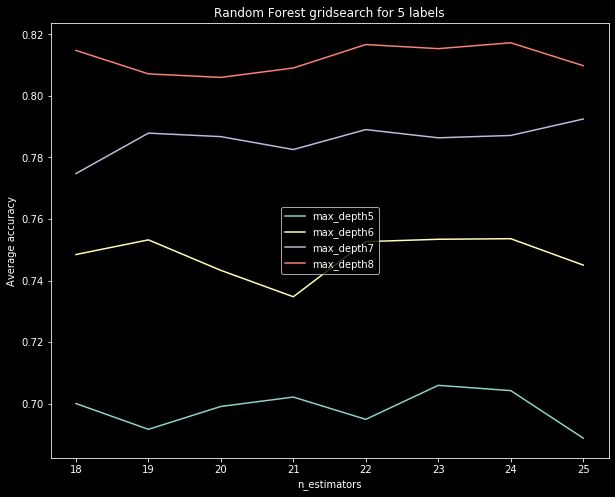

In [101]:
plot_cv_results(model_rf, params, 'Random Forest gridsearch')

In [49]:
feature_importance = pd.DataFrame({'features': recordings_librosa_avg_and_amplitude.columns[2:], 
                                  'importance': model_rf.best_estimator_.feature_importances_})
feature_importance.sort_values(by='importance', axis=0, ascending=False, inplace=True)

feature_importance

features  importance
29      avg_contrast6    0.112365
30      avg_contrast7    0.096643
38      amplitude_min    0.078674
40          s2n_ratio    0.073065
39      amplitude_max    0.069603
0           avg_mfcc1    0.048604
4           avg_mfcc5    0.045013
24      avg_contrast1    0.037316
37  amplitude_average    0.034905
6           avg_mfcc7    0.034611
2           avg_mfcc3    0.027981
26      avg_contrast3    0.027797
28      avg_contrast5    0.026576
25      avg_contrast2    0.026072
8           avg_mfcc9    0.022510
3           avg_mfcc4    0.019514
19        avg_chroma8    0.017972
10         avg_mfcc11    0.017427
5           avg_mfcc6    0.017352
1           avg_mfcc2    0.015161
18        avg_chroma7    0.014966
9          avg_mfcc10    0.014483
11         avg_mfcc12    0.011656
23       avg_chroma12    0.010524
7           avg_mfcc8    0.010271
27      avg_contrast4    0.009449
14        avg_chroma3    0.009260
17        avg_chroma6    0.008901
12        avg_chroma1    0.008190
20        avg_chroma9    0.008189
22       avg_chroma11    0.007880
21       avg_chroma10    0.006352
32       avg_tonnetz2    0.005460
13        avg_chroma2    0.004662
15        avg_chroma4    0.004326
16        avg_chroma5    0.004294
34       avg_tonnetz4    0.003165
33       avg_tonnetz3    0.003073
31       avg_tonnetz1    0.002273
36       avg_tonnetz6    0.001791
35       avg_tonnetz5    0.001676

In [50]:
def make_cnn(n_labels, n_features, size_recordings_2d=44, input_dimension=1):
    model = Sequential()
    
    if input_dimension == 1:
        #1st convolutional layer
        model.add(Conv1D(128, 5, padding='same', activation='relu',
                         input_shape=(n_features, 1)))
        #2nd convolutional layer
        model.add(Conv1D(128, 5, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=(6)))
        #3rd convolutional layer
        model.add(Conv1D(256, 5, padding='same', activation='relu'))
        model.add(Dropout(0.3))
        #4th convolutional layer
        model.add(Conv1D(256, 5, padding='same', activation='relu'))
        
    else:
        #1st convolutional layer
        model.add(Conv2D(128, 5, padding='same', activation='relu',
                         input_shape=(n_features, size_recordings_2d, 1)))
        #2nd convolutional layer
        model.add(Conv2D(128, 5, padding='same', activation='relu'))
        model.add(MaxPooling2D())
        #3rd convolutional layer
        model.add(Conv2D(256, 5, padding='same', activation='relu'))
        model.add(Dropout(0.3))
        #4th convolutional layer
        model.add(Conv2D(256, 5, padding='same', activation='relu'))
        
   #Final connected layer 
    model.add(Flatten())
    model.add(Dense(n_labels))
    model.add(Activation('softmax'))
    
    return model


def plot_model_history(history, plot_title='model loss'):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(plot_title + ' for ' + str(n_labels)+ ' labels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Train on 4230 samples, validate on 1058 samples
Epoch 1/40
4230/4230 [==============================] - 16s 4ms/step - loss: 1.2541 - acc: 0.5286 - val_loss: 0.6729 - val_acc: 0.7079
Epoch 2/40
4230/4230 [==============================] - 11s 3ms/step - loss: 0.7796 - acc: 0.6374 - val_loss: 0.6226 - val_acc: 0.7297
Epoch 3/40
4230/4230 [==============================] - 10s 2ms/step - loss: 0.7142 - acc: 0.6681 - val_loss: 0.5795 - val_acc: 0.7505
Epoch 4/40
4230/4230 [==============================] - 11s 3ms/step - loss: 0.6512 - acc: 0.7014 - val_loss: 0.5599 - val_acc: 0.7495
Epoch 5/40
4230/4230 [==============================] - 10s 2ms/step - loss: 0.6103 - acc: 0.7267 - val_loss: 0.5480 - val_acc: 0.7732
Epoch 6/40
4230/4230 [==============================] - 10s 2ms/step - loss: 0.5878 - acc: 0.7449 - val_loss: 0.5164 - val_acc: 0.7769
Epoch 7/40
4230/4230 [==============================] - 10s 2ms/step - loss: 0.5616 - acc: 0.7487 - val_loss: 0.4892 - val_acc: 0.7892
Epoch 8

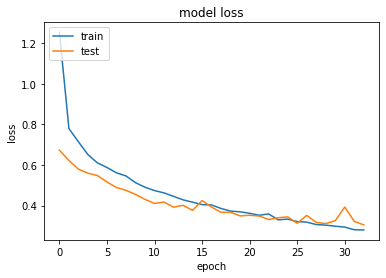

1322/1322 [==============================] - 1s 730us/step
Accuracy: 0.8585476550680786


In [110]:
'''model_filename = str(n_labels) + 'labels_model_cnn4_1s_mfcc_' + str(n_mfcc) + '_and_chroma_and_amplitude.sav'

if train_models:
    model_cnn = make_cnn(n_labels, X_train_cnn.shape[1], input_dimension=1)

    opt = Adam(lr=5e-5, decay=1e-6)
    model_cnn, history_cnn = train_model(model_cnn, 
                                         X_train_cnn, y_train_cnn, 
                                         models_path, model_filename,,
                                         opt, True)
    plot_model_history(history_cnn, 'CNN4 with MFCC, Chroma and Amplitude features')

else:
    model_cnn = load_model(os.path.join(models_path, model_filename))

print('Accuracy: {}'.format(model_cnn.evaluate(X_test_cnn, y_test_cnn)[1]))
print('Model saved at {}'.format(model_filename))'''

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 3389 samples, validate on 848 samples
Epoch 1/40
3389/3389 [==============================] - 272s 80ms/step - loss: 2.0032 - acc: 0.4255 - val_loss: 1.0612 - val_acc: 0.5672
Epoch 2/40
3389/3389 [==============================] - 157s 46ms/step - loss: 1.2440 - acc: 0.5403 - val_loss: 0.8367 - val_acc: 0.6627
Epoch 3/40
3389/3389 [==============================] - 168s 50ms/step - loss: 0.9874 - acc: 0.6008 - val_loss: 0.7779 - val_acc: 0.6851
Epoch 4/40
3389/3389 [==============================] - 174s 51ms/step - loss: 0.8962 - acc: 0.6267 - val_loss: 0.7565 - val_acc: 0.6934
Epoch 5/40
3389/3389 [==============================] - 153s 45ms/step - loss: 0.7772 - acc: 0.6816 - val_loss: 0.6891 - val_acc: 0.7300
Epoch 6/40
3389/3389 [===========

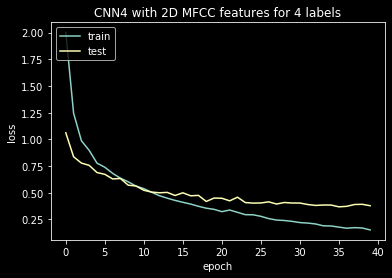

1060/1060 [==============================] - 11s 11ms/step
Accuracy: 0.8669811320754717
Model saved at 4labels_model_cnn4_1s_mfcc_12_2d.sav


In [33]:
if compute_2d_mfcc:
    model_filename = str(n_labels) + 'labels_model_cnn4_1s_mfcc_' + str(n_mfcc) + '_2d.sav'

    if train_models:
        
        model_cnn_mfcc_2d = make_cnn(n_labels, X_2d_train_mfcc.shape[1], X_2d_train_mfcc.shape[2], 
                                     input_dimension=2)

        opt = Adam(lr=1e-5, decay=1e-6)
        model_cnn_mfcc_2d, history_cnn_mfcc_2d = train_model(model_cnn_mfcc_2d, 
                                                             X_2d_train_mfcc, y_2d_train_mfcc, 
                                                             models_path, model_filename, 
                                                             opt, True)
        plot_model_history(history_cnn_mfcc_2d, 'CNN4 with 2D MFCC features')

    else:
        model_cnn_mfcc_2d = load_model(os.path.join(models_path, model_filename))

    print('Accuracy: {}'.format(model_cnn_mfcc_2d.evaluate(X_2d_test_mfcc, y_2d_test_mfcc)[1]))
    print('Model saved at {}'.format(model_filename))

In [ ]:
if compute_2d_mfcc_chroma:
    model_filename = str(n_labels) + 'labels_model_cnn4_1s_mfcc_' + str(n_mfcc) + '_and_chroma_2d.sav'

    if train_models:
        model_cnn_2d = make_cnn(n_labels, X_2d_train_mfcc_chroma.shape[1], X_2d_train_mfcc_chroma.shape[2], 
                                input_dimension=2)

        opt = Adam(lr=1e-5, decay=1e-6)
        model_cnn_2d, history_cnn_2d = train_model(model_cnn_mfcc_2d, 
                                                   X_2d_train_mfcc_chroma, y_2d_train_mfcc_chroma, 
                                                   models_path, model_filename, 
                                                   opt, True)
        plot_model_history(history_cnn_2d, 'CNN4 with 2D MFCC and Chroma features')

    else:
        model_cnn_2d = load_model(os.path.join(models_path, model_filename))

    print('Accuracy: {}'.format(model_cnn_2d.evaluate(X_2d_test_mfcc_chroma, y_2d_test_mfcc_chroma)[1]))
    print('Model saved at {}'.format(model_filename))

In [47]:
'''if compute_2d_mfcc_chroma:
    model_filename = str(n_labels) + 'labels_model_resnet50_1s_mfcc_' + str(n_mfcc) + '_and_chroma_2d.sav'
    
    if train_models:
        model_input = Input(shape=(24, 44, 1))

        #base_model = AveragePooling2D(pool_size=(2, 2))(model_input)
        base_model = Flatten()(model_input)
        base_model = RepeatVector(3)(base_model)
        base_model = Reshape((X_2d_train_mfcc_chroma.shape[1], X_2d_train_mfcc_chroma.shape[2], 3))(base_model)
        base_model = ResNet50(weights="imagenet", include_top=False)(base_model)

        #head_model = base_model.output
        head_model = Flatten()(base_model)
        head_model = Dense(128, activation="relu")(head_model)
        head_model = Dense(n_labels, activation="softmax")(head_model)

        # place the head model on top of the base model (this will become
        # the actual model we will train)
        model_resnet50 = Model(inputs=model_input, outputs=head_model)
        # Make sure the pre-trained model's layers aren't trained again
        model_resnet50.get_layer(name='resnet50').trainable = False

        opt = Adam(lr=1e-5, decay=1e-6)
        model_resnet50.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

        callbacks = [early_stop, ModelCheckpoint(os.path.join(models_path, model_filename),
                                                              monitor='val_loss', 
                                                              save_best_only=True, 
                                                              mode='min',
                                                              verbose=0)]
        history_resnet50 = model_resnet50.fit(X_2d_train_mfcc_chroma, y_2d_train_mfcc_chroma, 
                                            batch_size=32, epochs=40, validation_split=0.2,
                                            callbacks=callbacks)
        plot_model_history(history_resnet50, 'Resnet50')
    
    else:
        model_resnet50 = load_model(os.path.join(models_path, model_filename))
        
    print('Accuracy: {}'.format(model_resnet50.evaluate(X_2d_test_mfcc_chroma, y_2d_test_mfcc_chroma)[1]))'''

/Users/rym.laabiyad/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


1060/1060 [==============================] - 28s 26ms/step
Accuracy: 0.6617924528301887


Train on 4198 samples, validate on 1050 samples
Epoch 1/40
4198/4198 [==============================] - 84s 20ms/step - loss: 11.6693 - acc: 0.2170 - val_loss: 10.0176 - val_acc: 0.2133
Epoch 2/40
4198/4198 [==============================] - 82s 20ms/step - loss: 8.1047 - acc: 0.2382 - val_loss: 7.0061 - val_acc: 0.2467
Epoch 3/40
4198/4198 [==============================] - 81s 19ms/step - loss: 6.6008 - acc: 0.2785 - val_loss: 6.3329 - val_acc: 0.2638
Epoch 4/40
4198/4198 [==============================] - 81s 19ms/step - loss: 5.9652 - acc: 0.2944 - val_loss: 5.8240 - val_acc: 0.2790
Epoch 5/40
4198/4198 [==============================] - 85s 20ms/step - loss: 5.5083 - acc: 0.3030 - val_loss: 5.5015 - val_acc: 0.2838
Epoch 6/40
4198/4198 [==============================] - 80s 19ms/step - loss: 5.2059 - acc: 0.3204 - val_loss: 5.2763 - val_acc: 0.2952
Epoch 7/40
4198/4198 [==============================] - 81s 19ms/step - loss: 4.9807 - acc: 0.3297 - val_loss: 5.1077 - val_acc: 0.313

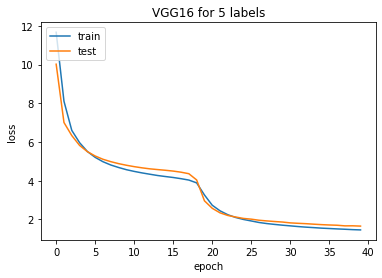

1313/1313 [==============================] - 21s 16ms/step
Accuracy: 0.5376999238385377
Model saved at 5labels_model_vgg16_1s_mfcc_20_and_chroma_2d.sav


In [49]:
if compute_2d_vgg:
    model_filename = str(n_labels) + 'labels_model_vgg16_1s_mfcc_20_and_chroma_2d.sav'
    
    if train_models:
        model_input = Input(shape=(X_2d_train_vgg.shape[1], X_2d_train_vgg.shape[2], 1))

        #base_model = AveragePooling2D(pool_size=(2, 2))(model_input)
        base_model = Flatten()(model_input)
        base_model = RepeatVector(3)(base_model)
        base_model = Reshape((X_2d_train_vgg.shape[1], X_2d_train_vgg.shape[2], 3))(base_model)
        base_model = VGG16(weights="imagenet", include_top=False)(base_model)

        #head_model = base_model.output
        head_model = Flatten()(base_model)
        head_model = Dense(128, activation="relu")(head_model)
        head_model = Dense(n_labels, activation="softmax")(head_model)

        # place the head model on top of the base model (this will become
        # the actual model we will train)
        model_vgg16 = Model(inputs=model_input, outputs=head_model)
        # Make sure the pre-trained model's layers aren't trained again
        model_vgg16.get_layer(name='vgg16').trainable = False

        opt = Adam(lr=1e-5, decay=1e-6)
        model_vgg16, history_vgg16 = train_model(model_vgg16, 
                                                 X_2d_train_vgg, y_2d_train_vgg,
                                                models_path, model_filename,
                                                opt, True)
        plot_model_history(history_vgg16, 'VGG16')
    
    else:
        model_vgg16 = load_model(os.path.join(models_path, model_filename))
        
    print('Accuracy: {}'.format(model_vgg16.evaluate(X_2d_test_vgg, y_2d_test_vgg)[1]))
    print('Model saved at {}'.format(model_filename))

In [39]:
L2_regularization = 0.001

def conv_recurrent_model_build(n_labels, n_features, parallel=True, size_recordings_2d=44):
    if parallel:
        ### Convolutional block
        model_conv = Sequential()       
        model_conv.add(Conv2D(padding= 'valid', activation='relu', name='conv_1',
                             input_shape=(n_features, size_recordings_2d, 1)))
        model_conv.add(MaxPooling2D((2,2)))
        mode_conv.add(Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                          padding= 'valid', activation='relu', name='conv_2'))
        mode_conv.add(MaxPooling2D((2,2)))
        mode_conv.add(Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                          padding= 'valid', activation='relu', name='conv_3'))
        mode_conv.add(MaxPooling2D((2,2)))
        mode_conv.add(Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                          padding= 'valid', activation='relu', name='conv_4'))
        mode_conv.add(MaxPooling2D((4,4)))

        mode_conv.add(Flatten())
        
        ### Recurrent Block
        model_par = Sequential()
        model_par.add(MaxPooling2D((4,2), name = 'pool_lstm'))
        squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)

        # Bidirectional GRU
        lstm = Bidirectional(GRU(lstm_count))(squeezed)
    else:
        model = Sequential()
        model.add(Conv1D(128, 5, padding='same', activation='relu',
                             input_shape=(n_features, 1)))
        model.add(BatchNormalization(momentum=0.9))
        model.add(MaxPooling1D())
        model.add(Dropout(0.4))
        model.add(Conv1D(128, 5, padding='same', activation='relu'))

        ## LSTM Layer
        model.add(LSTM(96, return_sequences=False))

        ## Dense Layer
        model.add(Dense(64, kernel_regularizer=regularizers.l2(L2_regularization)))
        model.add(Dropout(0.4))
    
    ## Softmax Output
    model.add(Dense(n_labels, activation='softmax'))

    return model

Train on 4198 samples, validate on 1050 samples
Epoch 1/40
4198/4198 [==============================] - 90s 21ms/step - loss: 1.4808 - acc: 0.3340 - val_loss: 1.2491 - val_acc: 0.4238
Epoch 2/40
4198/4198 [==============================] - 30s 7ms/step - loss: 1.2694 - acc: 0.4350 - val_loss: 1.3716 - val_acc: 0.4143
Epoch 3/40
4198/4198 [==============================] - 27s 6ms/step - loss: 1.1883 - acc: 0.4876 - val_loss: 1.0480 - val_acc: 0.5562
Epoch 4/40
4198/4198 [==============================] - 27s 6ms/step - loss: 1.1043 - acc: 0.5324 - val_loss: 1.0630 - val_acc: 0.5886
Epoch 5/40
4198/4198 [==============================] - 28s 7ms/step - loss: 1.0739 - acc: 0.5519 - val_loss: 0.9304 - val_acc: 0.5952
Epoch 6/40
4198/4198 [==============================] - 26s 6ms/step - loss: 1.0138 - acc: 0.5691 - val_loss: 0.9591 - val_acc: 0.6133
Epoch 7/40
4198/4198 [==============================] - 28s 7ms/step - loss: 0.9706 - acc: 0.5912 - val_loss: 0.8192 - val_acc: 0.6762
Epoch 

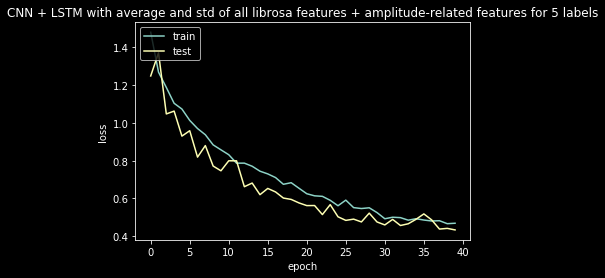

ValueError: Error when checking input: expected conv1d_11_input to have 3 dimensions, but got array with shape (1313, 78)

In [40]:
model_filename = str(n_labels) + 'labels_model_cnn_lstm_sequence_1s_mfcc_' + str(n_mfcc) + 'librosa_avg_std_and_amplitude.sav'
if train_models:
    opt = Adam(lr=1e-3, decay=1e-4)

    model_lstm = conv_recurrent_model_build(n_labels, X_avg_std_train.shape[1], False)
    model_lstm, history_lstm = train_model(model_lstm,
                                           X_avg_std_train_cnn, y_train_cnn,
                                           models_path, model_filename,
                                           opt, True)
    plot_model_history(history_lstm, 'CNN + LSTM with average and std of all librosa features + amplitude-related features')
    
else:
     model_lstm = load_model(os.path.join(models_path, model_filename))
        
print('Accuracy: {}'.format(model_lstm.evaluate(X_librosa_avg_std_amplitude_test_cnn, y_test_cnn)[1]))
print('Model saved at {}'.format(model_filename))

In [41]:
print('Accuracy: {}'.format(model_lstm.evaluate(X_librosa_avg_std_amplitude_test_cnn, y_test_cnn)[1]))

1313/1313 [==============================] - 5s 4ms/step
Accuracy: 0.8164508758568164


In [ ]:
model_filename = str(n_labels) + 'labels_model_cnn_lstm_parallel_1s_mfcc_' + str(n_mfcc) + '.sav'
if train_models:
    opt = Adam(lr=1e-3, decay=1e-5)

    model_lstm_parallel = conv_recurrent_model_build(n_labels, X_librosa_avg_std_amplitude_train.shape[1], True)
    model_lstm_parallel, history_lstm_parallel = train_model(model_lstm_parallel,
                                           X_librosa_avg_std_amplitude_train_cnn, y_train_cnn,
                                           models_path, model_filename,
                                           opt, True)
    plot_model_history(history_lstm_parallel, 'CNN + LSTM with average and std of all librosa features + amplitude-related features')
    
else:
     model_lstm_parallel = load_model(os.path.join(models_path, model_filename))
        
print('Accuracy: {}'.format(model_lstm_parallel.evaluate(X_librosa_avg_std_amplitude_test, y_test_cnn)[1]))
print('Model saved at {}'.format(model_filename))

In [45]:
def compare_one_row_results(row, col1, col2):
    if row[col1] == row[col2]:
        return 1
    else:
        return 0
    
def compare_two_columns(predictions, col1, col2):
    result = predictions.apply(compare_one_row_results, axis=1, args=(col1, col2))
    return sum(result)/len(result)

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def compare_results(predictions, remove_path=True):
    if remove_path:
        cols = predictions.columns[1:]
    else:
        cols = predictions.columns
        
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            print(cols[i], '-', cols[j], ':', 
                  100*compare_two_columns(predictions, cols[i], cols[j]), '% similar')  

In [47]:
preds = pd.DataFrame({'real': y_test})

preds['xgb'] = model_xgb.predict(X_test)
preds['rf'] = model_rf.predict(X_test)
preds['lstm_sequence'] = get_predictions_from_probas(model_lstm.predict(X_librosa_avg_std_amplitude_test_cnn))

if compute_2d_mfcc:
    preds['cnn_mfcc_2d'] = get_predictions_from_probas(model_cnn_mfcc_2d.predict(X_2d_test_mfcc))
    
if compute_2d_mfcc_chroma:
    preds['cnn_2d'] = get_predictions_from_probas(model_cnn_2d.predict(X_2d_test_mfcc_chroma))
    #preds['resnet50'] = get_predictions_from_probas(model_resnet50.predict(X_2d_test_mfcc_chroma))
if compute_2d_vgg:
    preds['vgg16'] = get_predictions_from_probas(model_vgg16.predict(X_2d_test_vgg))
    
compare_results(preds, False)
for l in np.unique(preds.real):
    print('\nFor label', reverse_labels_dict[int(l)])
    compare_results(preds[preds.real == l], False)

real - xgb : 87.58568164508759 % similar
real - rf : 79.96953541507997 % similar
real - lstm_sequence : 81.64508758568164 % similar
xgb - rf : 85.75780654988576 % similar
xgb - lstm_sequence : 81.4927646610815 % similar
rf - lstm_sequence : 78.5986290936786 % similar

For label neutral
real - xgb : 90.07633587786259 % similar
real - rf : 82.82442748091603 % similar
real - lstm_sequence : 91.6030534351145 % similar
xgb - rf : 90.83969465648855 % similar
xgb - lstm_sequence : 89.31297709923665 % similar
rf - lstm_sequence : 84.35114503816794 % similar

For label happy
real - xgb : 82.20640569395017 % similar
real - rf : 62.989323843416365 % similar
real - lstm_sequence : 75.80071174377224 % similar
xgb - rf : 76.15658362989323 % similar
xgb - lstm_sequence : 75.44483985765125 % similar
rf - lstm_sequence : 67.25978647686833 % similar

For label inaudible
real - xgb : 100.0 % similar
real - rf : 94.44444444444444 % similar
real - lstm_sequence : 92.5925925925926 % similar
xgb - rf : 94.44

## Evaluation on out-of-sample data

In [118]:
data_path_onetreehill = 'onetreehill/'

librosa_features_filename_outofsample = str(n_labels) + 'labels_librosa_features_' + str(n_mfcc) \
                                            + '_mfcc_onetreehill.pkl'
amplitude_features_filename_outofsample = str(n_labels) + 'labels_amplitude_onetreehill.pkl'

compute_librosa_features=True
compute_amplitude_features=True

In [119]:
if compute_librosa_features:
    recordings_outofsample = get_labelled_data(labelled_data_path, [data_path_onetreehill], labels_dict)
    print(recordings_outofsample.shape)
    
    recordings_librosa_features_outofsample = extract_features(extract_features_from_row,
                                                          recordings_outofsample,
                                                          labelled_data_path,
                                                          n_mfcc,
                                                         True) 
    recordings_librosa_features_outofsample.to_pickle(os.path.join(feature_engineering_path, 
                                                           librosa_features_filename_outofsample))
else:
    recordings_librosa_features_outofsample = pd.read_pickle(os.path.join(feature_engineering_path, 
                                                             librosa_features_filename_outofsample))
    recordings_outofsample = recordings_librosa_features_outofsample.iloc[:,:2]
    
print(recordings_librosa_features_outofsample.shape)

(38, 2)
Extracting features took 0:00:05.768039
(38, 39)


In [120]:
if compute_amplitude_features:
    recordings_amplitude_features_outofsample = extract_features(extract_amplitude_features,
                                                              recordings_outofsample,
                                                              labelled_data_path,
                                                              12,
                                                              True) 
    recordings_amplitude_features_outofsample.columns = ['paths', 'labels', 'average', 'min', 'max', 's2n_ratio']
    recordings_amplitude_features_outofsample.to_pickle(os.path.join(feature_engineering_path, 
                                                                     amplitude_features_filename_outofsample))
else:  
    recordings_amplitude_features_outofsample = pd.read_pickle(os.path.join(feature_engineering_path, 
                                                                            amplitude_features_filename_outofsample))
    
print(recordings_amplitude_features_outofsample.shape)

Extracting features took 0:00:01.764811
(38, 6)


In [83]:
recordings_outofsample = recordings_librosa_features_outofsample.iloc[:,:26]\
                            .merge(recordings_amplitude_features_outofsample.drop('labels', axis=1), 
                                   on='paths')

X_outofsample = recordings_outofsample.iloc[:,2:].to_numpy()
X_outofsample_cnn = np.expand_dims(X_outofsample, axis=2)
y_outofsample = recordings_outofsample.iloc[:,1].to_numpy()
print(X_outofsample.shape)

(40, 28)


In [106]:
if compute_2d_mfcc_chroma:
    features_outofsample = recordings_outofsample.paths.apply(extract_2d_features, 
                                                              args=(labelled_data_path, n_mfcc, True)).values

    features_2d_outofsample = np.zeros((features_outofsample.shape[0], 
                                        features_outofsample[0].shape[0], 
                                        features_outofsample[0].shape[1]))
    for i in range(features_outofsample.shape[0]):
        features_2d_outofsample[i] = features_outofsample[i]

    print(features_2d_outofsample.shape)
    
    X_2d_outofsample = np.expand_dims(features_2d_outofsample, axis=3)
    print(X_2d_outofsample.shape)

(40, 24, 44)
(40, 24, 44, 1)


In [107]:
preds_outofsample = pd.DataFrame({'paths': recordings_outofsample.paths,
                                  'real': recordings_outofsample.labels})

preds_outofsample['xgb'] = model_xgb.predict(X_outofsample)
preds_outofsample['rf'] = model_rf.predict(X_outofsample)
#preds_outofsample['cnn'] = get_predictions_from_probas(model_cnn.predict(X_outofsample_cnn))

if compute_2d_mfcc_chroma:
    preds_outofsample['cnn_2d'] = get_predictions_from_probas(model_cnn_2d.predict(X_2d_outofsample))

In [86]:
for model in preds_outofsample.iloc[:,1:].columns:
    unique, counts = np.unique(preds_outofsample[model], return_counts=True)
    print(model, dict(zip(unique, counts)))

real {1.0: 13, 2.0: 18, 3.0: 4, 4.0: 5}
xgb {0.0: 6, 1.0: 3, 2.0: 7, 3.0: 18, 4.0: 6}
rf {0.0: 8, 1.0: 3, 2.0: 9, 3.0: 19, 4.0: 1}
cnn_2d {1: 5, 2: 3, 3: 14, 4: 7, 5: 11}


In [108]:
preds_outofsample

paths  real  xgb   rf  cnn_2d
0           onetreehill/happy/onetreehill_chunk43.wav   1.0  4.0  3.0       4
1           onetreehill/happy/onetreehill_chunk41.wav   1.0  3.0  1.0       1
2             onetreehill/sad/onetreehill_chunk33.wav   3.0  2.0  1.0       2
3             onetreehill/sad/onetreehill_chunk32.wav   3.0  3.0  3.0       3
4             onetreehill/sad/onetreehill_chunk19.wav   3.0  2.0  2.0       4
5             onetreehill/sad/onetreehill_chunk31.wav   3.0  4.0  3.0       4
6   onetreehill/neutral/03-01-01-01-01-01-02_chunk...   1.0  3.0  3.0       3
7         onetreehill/neutral/onetreehill_chunk44.wav   1.0  3.0  3.0       4
8   onetreehill/neutral/03-01-01-01-01-01-02_chunk...   1.0  4.0  1.0       3
9         onetreehill/neutral/onetreehill_chunk18.wav   1.0  2.0  3.0       4
10        onetreehill/neutral/onetreehill_chunk23.wav   1.0  4.0  1.0       4
11  onetreehill/neutral/03-01-01-01-01-01-03_chunk...   1.0  3.0  3.0       1
12        onetreehill/neutral/onetreehill_chunk15.wav   1.0  3.0  2.0       1
13  onetreehill/neutral/03-01-01-01-01-01-03_chunk...   1.0  1.0  3.0       4
14        onetreehill/neutral/onetreehill_chunk17.wav   1.0  2.0  3.0       1
15  onetreehill/neutral/03-01-01-01-01-01-01_chunk...   1.0  3.0  3.0       3
16  onetreehill/neutral/03-01-01-01-01-01-01_chunk...   1.0  3.0  3.0       1
17          onetreehill/angry/onetreehill_chunk64.wav   4.0  3.0  1.0       3
18          onetreehill/angry/onetreehill_chunk63.wav   4.0  2.0  1.0       4
19          onetreehill/angry/onetreehill_chunk62.wav   4.0  1.0  3.0       3
20          onetreehill/angry/onetreehill_chunk60.wav   4.0  3.0  3.0       4
21          onetreehill/angry/onetreehill_chunk61.wav   4.0  3.0  1.0       4
22       onetreehill/inaudible/onetreehill_chunk4.wav   2.0  2.0  1.0       2
23       onetreehill/inaudible/onetreehill_chunk5.wav   2.0  2.0  1.0       2
24       onetreehill/inaudible/onetreehill_chunk7.wav   2.0  1.0  1.0       2
25       onetreehill/inaudible/onetreehill_chunk6.wav   2.0  1.0  1.0       1
26       onetreehill/inaudible/onetreehill_chunk2.wav   2.0  1.0  2.0       2
27      onetreehill/inaudible/onetreehill_chunk21.wav   2.0  2.0  3.0       2
28      onetreehill/inaudible/onetreehill_chunk20.wav   2.0  2.0  3.0       2
29       onetreehill/inaudible/onetreehill_chunk3.wav   2.0  2.0  2.0       2
30       onetreehill/inaudible/onetreehill_chunk1.wav   2.0  3.0  2.0       2
31      onetreehill/inaudible/onetreehill_chunk22.wav   2.0  4.0  2.0       4
32       onetreehill/inaudible/onetreehill_chunk0.wav   2.0  3.0  2.0       2
33      onetreehill/inaudible/onetreehill_chunk12.wav   2.0  3.0  3.0       2
34      onetreehill/inaudible/onetreehill_chunk13.wav   2.0  2.0  2.0       2
35      onetreehill/inaudible/onetreehill_chunk11.wav   2.0  2.0  3.0       2
36      onetreehill/inaudible/onetreehill_chunk10.wav   2.0  3.0  3.0       2
37      onetreehill/inaudible/onetreehill_chunk28.wav   2.0  3.0  4.0       4
38       onetreehill/inaudible/onetreehill_chunk8.wav   2.0  2.0  3.0       2
39       onetreehill/inaudible/onetreehill_chunk9.wav   2.0  3.0  2.0       2

In [114]:
preds_outofsample.drop([13,15], inplace=True)

In [115]:
compare_results(preds_outofsample)
for l in np.unique(preds_outofsample.xgb):
    print('\nFor label', reverse_labels_dict[int(l)])
    compare_results(preds_outofsample[preds_outofsample.real == l])

real - xgb : 23.684210526315788 % similar
real - rf : 31.57894736842105 % similar
real - cnn_2d : 63.1578947368421 % similar
xgb - rf : 34.21052631578947 % similar
xgb - cnn_2d : 44.73684210526316 % similar
rf - cnn_2d : 31.57894736842105 % similar

For label neutral/positive
real - xgb : 0.0 % similar
real - rf : 27.27272727272727 % similar
real - cnn_2d : 45.45454545454545 % similar
xgb - rf : 36.36363636363637 % similar
xgb - cnn_2d : 27.27272727272727 % similar
rf - cnn_2d : 18.181818181818183 % similar

For label inaudible
real - xgb : 44.44444444444444 % similar
real - rf : 38.88888888888889 % similar
real - cnn_2d : 83.33333333333334 % similar
xgb - rf : 33.33333333333333 % similar
xgb - cnn_2d : 55.55555555555556 % similar
rf - cnn_2d : 44.44444444444444 % similar

For label sad
real - xgb : 25.0 % similar
real - rf : 50.0 % similar
real - cnn_2d : 25.0 % similar
xgb - rf : 50.0 % similar
xgb - cnn_2d : 75.0 % similar
rf - cnn_2d : 25.0 % similar

For label angry
real - xgb : 0

## Using the waveplot image to classify

'/Users/rym.laabiyad/RogerVoice/data_1s/labelled/youtube/happy/revolutionaryroad_chunk41_chunk1.png'

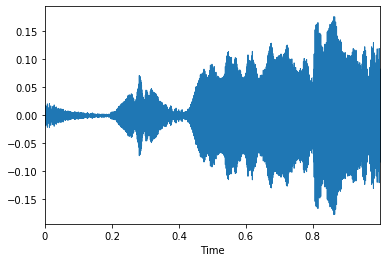

In [33]:
plot_waveform(os.path.join(labelled_data_path, recordings.iloc[0,0]))

In [32]:
def plot_waveform(path):
    audio_data, sampling_rate = librosa.load(path)
    librosa.display.waveplot(audio_data, sr=sampling_rate)
    img_path = path[:-4] + '_waveplot.png'
    plt.savefig(os.path.join(labelled_data_path, img_path))
    
    return img_path
    
def plot_spectral(path):
    audio_data, sampling_rate = librosa.load(path)
    d = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    librosa.display.specshow(d, sr=sampling_rate, y_axis='log')